In [23]:
import chardet
import numpy as np
import pandas as pd

filepath = "D:\\test002.csv"
#filepath ="D:\Stock prediction\stock-prediction2\data_set\\test003.csv"
#filepath = "D:\Stock prediction\stock-prediction2\data_set\\rlData.csv"
#with open('D:\Stock prediction\stock-prediction2\data_set\\test003.csv', 'rb') as f:
    #result = chardet.detect(f.read())
#encoding = result['encoding']

# 读取文件
#data = pd.read_csv('D:\Stock prediction\stock-prediction2\data_set\\test003.csv', encoding=encoding)

#filepath = "D:\\Stock prediction\\stock-prediction2\\data_set\\test.csv"
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close2,SGX,PC1,Close
6,2018/1/10,575.0,576.5,566.0,574.5,77.84,0.288555,574.5
7,2018/1/11,572.5,573.5,564.5,571.0,77.60,0.270552,571.0
8,2018/1/12,569.5,570.5,551.5,570.0,77.44,0.276958,570.0
9,2018/1/15,556.0,560.0,548.0,558.0,77.40,0.267161,558.0
10,2018/1/16,555.0,562.0,545.5,553.5,76.59,0.276089,553.5


In [24]:
data.shape

(730, 8)

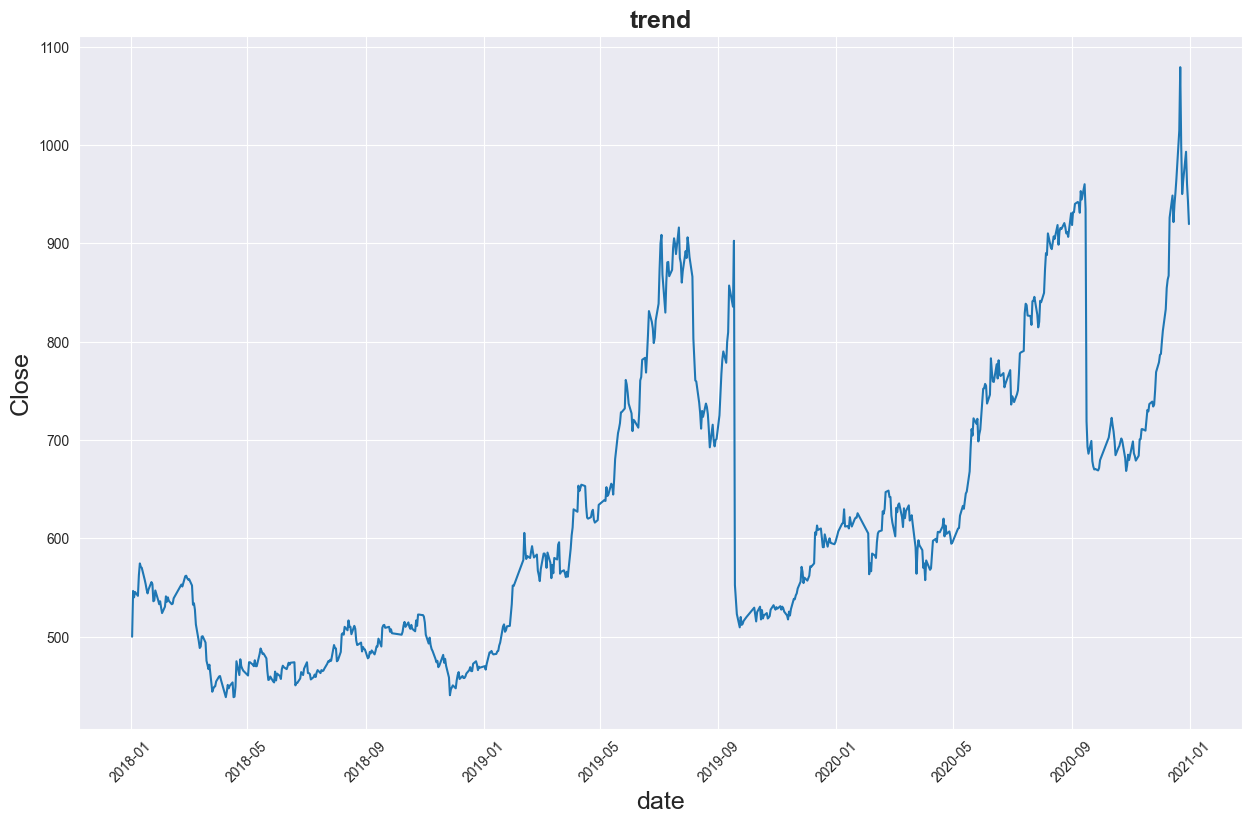

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# 从CSV文件中读取数据
data = pd.read_csv("D:\\test002.csv")

# 转换日期列为日期类型
data['Date'] = pd.to_datetime(data['Date'])

# 转换收盘价列为浮点数类型
data['Close'] = data['Close'].astype(float)

# 提取需要绘制的列数据
x = data['Date']
y = data['Close']

# 绘制折线图

plt.figure(figsize = (15,9))
plt.title('trend',fontsize=18, fontweight='bold')
plt.xlabel('date',fontsize=18)
plt.ylabel('Close',fontsize=18)
# 设置x轴刻度
plt.xticks(rotation=45)
plt.plot(x, y)

# 显示图形
plt.show()#


# 1. 特征工程

In [26]:
price = data[['Close', 'Open']]

price

,Close,Open
0,500.0,535.0
1,546.5,545.0
2,540.0,539.0
3,545.5,547.0
4,541.5,541.0
...,...,...
725,963.0,956.0
726,993.0,993.0
727,960.5,960.5
728,942.5,940.0


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\李德杰\AppData\Local\Temp\ipykernel_22792\68737012.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
price['Open'] = scaler.fit_transform(price['Open'].values.reshape(-1,1))
#price['SGX'] = scaler.fit_transform(price['SGX'].values.reshape(-1,1))
#price['PC1'] = scaler.fit_transform(price['PC1'].values.reshape(-1,1))
price

C:\Users\李德杰\AppData\Local\Temp\ipykernel_22792\4202277762.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,Open
0,-0.807963,-0.687852
1,-0.662763,-0.655672
2,-0.683060,-0.674980
3,-0.665886,-0.649236
4,-0.678376,-0.668544
...,...,...
725,0.637783,0.666935
726,0.731460,0.786002
727,0.629977,0.681416
728,0.573770,0.615447


# 2. 数据集制作

In [29]:
def split_data(stock, lookback): 
    data_raw = stock.to_numpy() 
    data = []
    
    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    #每个样本的前十九个
    y_train = data[:train_set_size,-1,0:1]
    #每个样本最后的一个
    x_test = data[train_set_size:,:-1,:]
    
    y_test = data[train_set_size:,-1,0:1]
    
    return [x_train, y_train, x_test, y_test]

In [30]:
lookback = 20
#步长的大小 
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (568, 19, 2)
y_train.shape =  (568, 1)
x_test.shape =  (142, 19, 2)
y_test.shape =  (142, 1)


注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)

# 3. 模型构建 —— LSTM

In [31]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
#y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
#y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [32]:
input_dim = 2
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 300

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [34]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. 模型训练

In [35]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.4822019040584564
Epoch  1 MSE:  0.2888067066669464
Epoch  2 MSE:  0.11861692368984222
Epoch  3 MSE:  0.1664203256368637
Epoch  4 MSE:  0.11711534112691879
Epoch  5 MSE:  0.08041515946388245
Epoch  6 MSE:  0.08538243174552917
Epoch  7 MSE:  0.09410639107227325
Epoch  8 MSE:  0.09180571138858795
Epoch  9 MSE:  0.07799651473760605
Epoch  10 MSE:  0.05835969001054764
Epoch  11 MSE:  0.043287452310323715
Epoch  12 MSE:  0.043365154415369034
Epoch  13 MSE:  0.050008565187454224
Epoch  14 MSE:  0.039878614246845245
Epoch  15 MSE:  0.022532761096954346
Epoch  16 MSE:  0.016583679243922234
Epoch  17 MSE:  0.022117361426353455
Epoch  18 MSE:  0.02610868029296398
Epoch  19 MSE:  0.02055531181395054
Epoch  20 MSE:  0.013025856576859951
Epoch  21 MSE:  0.014952128753066063
Epoch  22 MSE:  0.021305866539478302
Epoch  23 MSE:  0.01941678300499916
Epoch  24 MSE:  0.012742908671498299
Epoch  25 MSE:  0.010362011380493641
Epoch  26 MSE:  0.012574483640491962
Epoch  27 MSE:  0.0144561063

Epoch  41 MSE:  0.006926408503204584
Epoch  42 MSE:  0.007436624728143215
Epoch  43 MSE:  0.007645236793905497
Epoch  44 MSE:  0.007068715523928404
Epoch  45 MSE:  0.006454214453697205
Epoch  46 MSE:  0.006488058250397444
Epoch  47 MSE:  0.006823375821113586
Epoch  48 MSE:  0.0067618065513670444
Epoch  49 MSE:  0.006264661438763142
Epoch  50 MSE:  0.005893681198358536
Epoch  51 MSE:  0.005950242280960083
Epoch  52 MSE:  0.006079584825783968
Epoch  53 MSE:  0.005890300031751394
Epoch  54 MSE:  0.0055531663820147514
Epoch  55 MSE:  0.005443070083856583
Epoch  56 MSE:  0.005547425244003534
Epoch  57 MSE:  0.005563145037740469
Epoch  58 MSE:  0.005376583896577358
Epoch  59 MSE:  0.005184615962207317
Epoch  60 MSE:  0.005160248838365078
Epoch  61 MSE:  0.005194870289415121
Epoch  62 MSE:  0.005101223010569811
Epoch  63 MSE:  0.004925119690597057
Epoch  64 MSE:  0.004843199625611305
Epoch  65 MSE:  0.004860646091401577
Epoch  66 MSE:  0.0048299129121005535
Epoch  67 MSE:  0.00471138441935181

# 5. 模型结果可视化

In [36]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

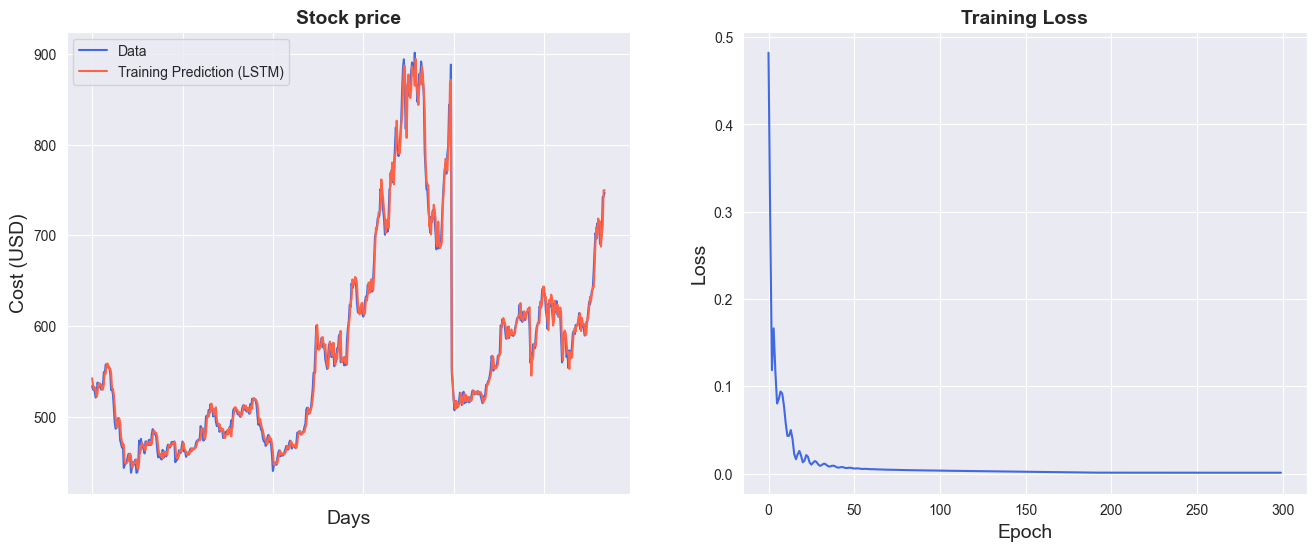

In [37]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

# 6. 模型验证

In [38]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 10.31 RMSE
Test Score: 18.04 RMSE


注意Price此时的维度

In [39]:
# 注意这里标签索引是一个列表
new_price = price[['Close']]
new_price

,Close
0,-0.807963
1,-0.662763
2,-0.683060
3,-0.665886
4,-0.678376
...,...
725,0.637783
726,0.731460
727,0.629977
728,0.573770


In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(new_price)
trainPredictPlot[:, 0] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

In [41]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(new_price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

In [42]:
original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))
#因为之前有过归一化，所以要反向归一化回去
predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)#并不是在原predictions的基础上
#在给定的代码中，首先将trainPredictPlot和testPredictPlot
#两个NumPy数组沿着列轴（axis=1）进行拼接，并将结果赋值给`predictions`。
# 这将产生一个新的NumPy数组，其中包含了训练集和测试集的预测结果。
#接下来，使用np.append()函数将original数组也沿着列轴（axis=1）拼接到`predictions`数组的末尾。
# 这样做的目的是将原始数据与预测结果进行对比，将它们放在同一个数组中。
#最终，predictions数组将包含三列数据，
# 分别是trainPredictPlot`数组、testPredictPlot数组和original数组的内容。

result = pd.DataFrame(predictions)

In [43]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='black',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close ',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    template = 'plotly_white'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [44]:
# 构建新特征 --> 滞后